# **TEXT MINING PROJECT**: 20 NEWS GROUP CLASSIFICATION  

Antonella Zaccaria  
Marco Savino

**Pipeline**

![picture](https://drive.google.com/uc?id=1nAJkGnNtoIbfOo7XdpTtSdep1bfyAavD)

Librerie utilizzate

In [0]:
import nltk
nltk.download('wordnet')
nltk.download('punkt') #serve per la tokenizzazione
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
from sklearn.datasets import fetch_20newsgroups

import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer

from sklearn import model_selection, preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score 

from sklearn.model_selection import cross_val_score

from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

Carichiamo il dataset 20 News Group direttamente dal **sklearn** e lo salviamo in formato csv

In [0]:
def twenty_newsgroup_to_csv():
    newsgroups = fetch_20newsgroups(subset = 'all', shuffle=True)

    df = pd.DataFrame([newsgroups.data, newsgroups.target.tolist()]).T
    df.columns = ['text', 'target']
    targets = pd.DataFrame(newsgroups.target_names)
    targets.columns=['title']

    out = pd.merge(df, targets, left_on='target', right_index=True)
    out.to_csv('20_news.csv')
    
  
twenty_newsgroup_to_csv()

In [0]:
df = pd.read_csv('20_news.csv')

Visualizziamo le prime righe del dataset

In [0]:
df.head()

,Unnamed: 0,text,target,title
0,0,From: Mamatha Devineni Ratnam <mr47+@andrew.cm...,10,rec.sport.hockey
1,7,From: dchhabra@stpl.ists.ca (Deepak Chhabra)\n...,10,rec.sport.hockey
2,8,From: dchhabra@stpl.ists.ca (Deepak Chhabra)\n...,10,rec.sport.hockey
3,24,From: cs902043@ariel.yorku.ca (SHAWN LUDDINGTO...,10,rec.sport.hockey
4,44,From: gritter@cs.purdue.edu (Carl Gritter)\nSu...,10,rec.sport.hockey


Eliminiamo la colonna **Unnamed: 0**

In [0]:
df = df.drop('Unnamed: 0', 1)

In [0]:
df.head()

,text,target,title
0,From: Mamatha Devineni Ratnam <mr47+@andrew.cm...,10,rec.sport.hockey
1,From: dchhabra@stpl.ists.ca (Deepak Chhabra)\n...,10,rec.sport.hockey
2,From: dchhabra@stpl.ists.ca (Deepak Chhabra)\n...,10,rec.sport.hockey
3,From: cs902043@ariel.yorku.ca (SHAWN LUDDINGTO...,10,rec.sport.hockey
4,From: gritter@cs.purdue.edu (Carl Gritter)\nSu...,10,rec.sport.hockey


## **Data esploration**

Dimensione del dataset

In [0]:
df.shape

(18846, 3)

Controlliamo se sono presenti **na**

In [0]:
df.isnull().sum()

text      0
target    0
title     0
dtype: int64

Lista target

In [0]:
print(df.title.unique())

['rec.sport.hockey' 'comp.sys.ibm.pc.hardware' 'talk.politics.mideast'
 'comp.sys.mac.hardware' 'sci.electronics' 'talk.religion.misc'
 'sci.crypt' 'sci.med' 'alt.atheism' 'rec.motorcycles' 'rec.autos'
 'comp.windows.x' 'comp.graphics' 'sci.space' 'talk.politics.guns'
 'misc.forsale' 'rec.sport.baseball' 'talk.politics.misc'
 'comp.os.ms-windows.misc' 'soc.religion.christian']


In [0]:
print(df.target.unique())

[10  3 17  4 12 19 11 13  0  8  7  5  1 14 16  6  9 18  2 15]


Controlliamo se le categorie (target) sono bilanciate

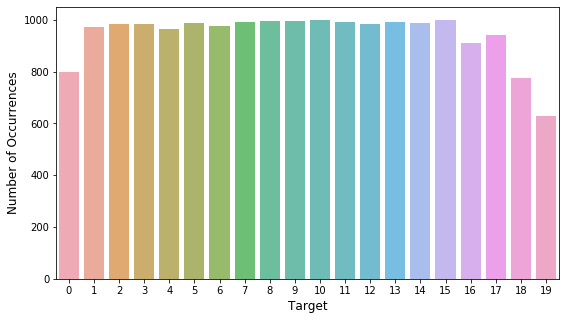

In [0]:
count_target = df['target'].value_counts()

plt.figure(figsize=(9,5))
sns.barplot(count_target.index, count_target.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Target', fontsize=12);

## **Preprocessing**

Per le operazioni di preprocessing creiamo una nuova colonna del DataFrame df chiamata **text_processed**, mantenendo la colonna del testo originale

**1.** Conversione del testo in minuscolo

In [0]:
df['text_processed'] = df['text'].map(lambda x: x.lower())

**2.** Eliminazione indirizzi mail

In [0]:
df['text_processed'] = df['text_processed'].map(lambda x: re.sub('\S*@\S*\s?',' ', x))

**3.** Eliminazione numeri

In [0]:
df['text_processed'] = df['text_processed'].map(lambda x: re.sub('\d+',' ', x))

**4.** Eliminazione caratteri di punteggiatura

In [0]:
df['text_processed'] = df['text_processed'].map(lambda x: re.sub(r'[^\w]', ' ', x))

**5.** Rimozione parole composta da 1 e due lettere

In [0]:
df['text_processed'] = df['text_processed'].astype(str).map(lambda x: re.sub(r'\b\w{1,2}\b', '', x))

**6.** Sistemazione degli spazi che si sono creati con le precedenti operazioni

In [0]:
df['text_processed'] = df['text_processed'].map(lambda x: re.sub(' +', ' ', x))

In [0]:
df['text_processed'] = df['text_processed'].map(lambda x: x.lstrip()) #rimozione spazi di inizio riga

In [0]:
df['text_processed'] = df['text_processed'].map(lambda x: x.rstrip()) #rimozione spazi di fine riga

**7.** Tokenizzazione

In [0]:
df['text_processed'] = df['text_processed'].apply(lambda x: nltk.word_tokenize(x))

**8.** Rimozione Stopwords

In [0]:
#lista stop_words
en_stopwords = stopwords.words ('english')

In [0]:
#numero di stopwords
len(en_stopwords)

179

In [0]:
df['text_processed'] = df['text_processed'].apply(lambda x: [item for item in x if item not in en_stopwords])

Per effettuare le operazioni di lemmatizzazione e stemming verranno create quattro nuove colonne (rispettivamente **text_processed_lem**,  **text_processed_stem_porter**, **text_processed_stem_snowball** e **text_processed_stem_lancaster**) in modo da tenere separate le operazioni di lem e stem

**9.** Lemmatizzazione  

In [0]:
lemmatizer = WordNetLemmatizer()

In [0]:
df['text_processed_lem'] = df['text_processed'].apply(lambda x: [lemmatizer.lemmatize(y) for y in x])

**10.** Stemming

**10.1** Porter Stemmer

In [0]:
ps = PorterStemmer()

In [0]:
df['text_processed_stem_porter'] = df['text_processed'].apply(lambda x: [ps.stem(y) for y in x])

**10.2** Snowball Stemmer

In [0]:
from nltk.stem.snowball import SnowballStemmer

In [0]:
ss = SnowballStemmer("english")

In [0]:
df['text_processed_stem_snowball'] = df['text_processed'].apply(lambda x: [ss.stem(y) for y in x])

**10.3** Lancaster Stemmer

In [0]:
from nltk.stem import LancasterStemmer

In [0]:
ls = LancasterStemmer()

In [0]:
df['text_processed_stem_lancaster'] = df['text_processed'].apply(lambda x: [ls.stem(y) for y in x])

Teminata la fase di preprocessing del testo suddividiamo il Dataset in **train set (70%)** e **test set (30%)** in modo da poter addestrare e testare il classificatore  

**train_lem_x**: train set  di text_processed_lem  
**train_lem_y**: target train set di text_processed_lem  
**test_lem_x**: test set di text_processed_lem   
**test_lem_y**: target test di text_processed_lem 

**train_stem_porter_x**: train set  di text_processed_stem_porter  
**train_stem_porter_y**: target train set di text_processed_stem_porter    
**test_stem_porter_x**: test set di text_processed_stem_porter     
**test_stem_porter_y**: target test di text_processed_stem_porter  

**train_stem_snowball_x**: train set  di text_processed_stem_snowball  
**train_stem_porter_snowball_y**: target train set di text_processed_stem_snowball      
**test_stem_porter_snowball_x**: test set di text_processed_stem_snowball       
**test_stem_porter_snowball_y**: target test di text_processed_stem_snowball  

**train_stem_lancaster_x**: train set  di text_processed_stem_lancaster    
**train_stem_porter_lancaster_y**: target train set di text_processed_stem_lancaster        
**test_stem_porter_lancaster_x**: test set di text_processed_stem_lancaster         
**test_stem_porter_lancaster_y**: target test di text_processed_stem_lancaster  


In [0]:
train_lem_x, test_lem_x, train_lem_y, test_lem_y = model_selection.train_test_split(df['text_processed_lem'], df['target'], 
                                                                                    train_size= 0.7, test_size= 0.3, 
                                                                                    random_state = 123, shuffle = True)

In [0]:
train_stem_porter_x, test_stem_porter_x, train_stem_porter_y, test_stem_porter_y = model_selection.train_test_split(df['text_processed_stem_porter'], df['target'], 
                                                                                    train_size= 0.7, test_size= 0.3, 
                                                                                    random_state = 123, shuffle = True)

In [0]:
train_stem_snowball_x, test_stem_snowball_x, train_stem_snowball_y, test_stem_snowball_y = model_selection.train_test_split(df['text_processed_stem_snowball'], df['target'], 
                                                                                    train_size= 0.7, test_size= 0.3, 
                                                                                    random_state = 123, shuffle = True)

In [0]:
train_stem_lancaster_x, test_stem_lancaster_x, train_stem_lancaster_y, test_stem_lancaster_y = model_selection.train_test_split(df['text_processed_stem_lancaster'], df['target'], 
                                                                                    train_size= 0.7, test_size= 0.3, 
                                                                                    random_state = 123, shuffle = True)

In [0]:
print('La dimensione del train set dei dati "lemmatizzati" (train_lem_x) è', len(train_lem_x))
print('La dimensione del test set dei dati "lemmatizzati" (test_lem_x) è', len(test_lem_x))

print('La dimensione del train set dei dati "stemmatizzati (Porter)" (train_stem_porter_x) è', len(train_stem_porter_x))
print('La dimensione del test set dei dati "stemmatizzati (Porter)" (test_stem_porter_x) è', len(test_stem_porter_x))

print('La dimensione del train set dei dati "stemmatizzati (Snowball)" (train_stem_snowball_x) è', len(train_stem_snowball_x))
print('La dimensione del test set dei dati "stemmatizzati (Snowball)" (test_stem_snowball_x) è', len(test_stem_snowball_x))

print('La dimensione del train set dei dati "stemmatizzati (Lancaster)" (train_stem_lancaster_x) è', len(train_stem_lancaster_x))
print('La dimensione del test set dei dati "stemmatizzati (Lancaster)" (test_stem_lancaster_x) è', len(test_stem_lancaster_x))


La dimensione del train set dei dati "lemmatizzati" (train_lem_x) è 13192
La dimensione del test set dei dati "lemmatizzati" (test_lem_x) è 5654
La dimensione del train set dei dati "stemmatizzati (Porter)" (train_stem_porter_x) è 13192
La dimensione del test set dei dati "stemmatizzati (Porter)" (test_stem_porter_x) è 5654
La dimensione del train set dei dati "stemmatizzati (Snowball)" (train_stem_snowball_x) è 13192
La dimensione del test set dei dati "stemmatizzati (Snowball)" (test_stem_snowball_x) è 5654
La dimensione del train set dei dati "stemmatizzati (Lancaster)" (train_stem_lancaster_x) è 13192
La dimensione del test set dei dati "stemmatizzati (Lancaster)" (test_stem_lancaster_x) è 5654


## **Feature Engineering**  
In questa fase creiamo le strutture **tf** e **tf-idf** che saranno poi utilizzate dagli algoritmi di Machine Learning per effettuare la classificazione

**Term Frequency**

In [0]:
count_vect = CountVectorizer(analyzer='word')

I successivi otto passaggi servono per adeguare il formato alla funzione di creazione delle matrici tf e tf-idf

In [0]:
a = train_lem_x.astype(str)

In [0]:
b = test_lem_x.astype(str)

In [0]:
c = train_stem_porter_x.astype(str)

In [0]:
d = test_stem_porter_x.astype(str)

In [0]:
e = train_stem_snowball_x.astype(str)

In [0]:
f = test_stem_snowball_x.astype(str)

In [0]:
g = train_stem_lancaster_x.astype(str)

In [0]:
h = test_stem_lancaster_x.astype(str)

Creazione matrice tf per train_lem_x

In [0]:
tf_train_lem_x = count_vect.fit_transform(a)
tf_train_lem_x

<13192x78462 sparse matrix of type '<class 'numpy.int64'>'
	with 1315155 stored elements in Compressed Sparse Row format>

Creazione matrice tf per test_lem_x

In [0]:
tf_test_lem_x = count_vect.transform(b)
tf_test_lem_x

<5654x78462 sparse matrix of type '<class 'numpy.int64'>'
	with 549716 stored elements in Compressed Sparse Row format>

Creazione matrice tf per train_stem_porter_x

In [0]:
tf_train_stem_porter_x = count_vect.fit_transform(c)
tf_train_stem_porter_x

<13192x64774 sparse matrix of type '<class 'numpy.int64'>'
	with 1271165 stored elements in Compressed Sparse Row format>

Creazione matrice tf per test_stem_porter_x

In [0]:
tf_test_stem_porter_x = count_vect.transform(d)
tf_test_stem_porter_x

<5654x64774 sparse matrix of type '<class 'numpy.int64'>'
	with 534196 stored elements in Compressed Sparse Row format>

Creazione matrice tf per train_stem_snowball_x

In [0]:
tf_train_stem_snowball_x = count_vect.fit_transform(e)
tf_train_stem_snowball_x

<13192x64592 sparse matrix of type '<class 'numpy.int64'>'
	with 1270062 stored elements in Compressed Sparse Row format>

Creazione matrice tf per test_stem_snowball_x

In [0]:
tf_test_stem_snowball_x = count_vect.transform(f)
tf_test_stem_snowball_x

<5654x64592 sparse matrix of type '<class 'numpy.int64'>'
	with 533743 stored elements in Compressed Sparse Row format>

Creazione matrice tf per train_stem_lancaster_x

In [0]:
tf_train_stem_lancaster_x = count_vect.fit_transform(g)
tf_train_stem_lancaster_x

<13192x55921 sparse matrix of type '<class 'numpy.int64'>'
	with 1246743 stored elements in Compressed Sparse Row format>

Creazione matrice tf per test_stem_lancaster_x

In [0]:
tf_test_stem_lancaster_x = count_vect.transform(h)
tf_test_stem_lancaster_x

<5654x55921 sparse matrix of type '<class 'numpy.int64'>'
	with 526015 stored elements in Compressed Sparse Row format>

**TF-IDF unigram** 

In [0]:
tfidf = TfidfVectorizer(max_features=20000, analyzer='word', ngram_range=(1,1))

Creazione matrice tf-idf per train_lem_x

In [0]:
tfidf.fit(a)
tfidf_train_lem_x =  tfidf.transform(a)

In [0]:
tfidf_train_lem_x

<13192x20000 sparse matrix of type '<class 'numpy.float64'>'
	with 1218276 stored elements in Compressed Sparse Row format>

Creazione matrice tf-idf per test_lem_x

In [0]:
tfidf_test_lem_x =  tfidf.transform(b)

In [0]:
tfidf_test_lem_x

<5654x20000 sparse matrix of type '<class 'numpy.float64'>'
	with 518723 stored elements in Compressed Sparse Row format>

Creazione matrice tf-idf per train_stem_porter_x

In [0]:
tfidf.fit(c)
tfidf_train_stem_porter_x =  tfidf.transform(c)

In [0]:
tfidf_train_stem_porter_x

<13192x20000 sparse matrix of type '<class 'numpy.float64'>'
	with 1207309 stored elements in Compressed Sparse Row format>

Creazione matrice tf-idf per test_stem_porter_x

In [0]:
tfidf_test_stem_porter_x =  tfidf.transform(d)

In [0]:
tfidf_test_stem_porter_x

<5654x20000 sparse matrix of type '<class 'numpy.float64'>'
	with 514858 stored elements in Compressed Sparse Row format>

Creazione matrice tf-idf per train_stem_snowball_x

In [0]:
tfidf.fit(e)
tfidf_train_stem_snowball_x =  tfidf.transform(e)

In [0]:
tfidf_train_stem_snowball_x

<13192x20000 sparse matrix of type '<class 'numpy.float64'>'
	with 1206779 stored elements in Compressed Sparse Row format>

Creazione matrice tf-idf per test_stem_snowball_x

In [0]:
tfidf_test_stem_snowball_x =  tfidf.transform(f)

In [0]:
tfidf_test_stem_snowball_x

<5654x20000 sparse matrix of type '<class 'numpy.float64'>'
	with 514716 stored elements in Compressed Sparse Row format>

Creazione matrice tf-idf per train_stem_lancaster_x

In [0]:
tfidf.fit(g)
tfidf_train_stem_lancaster_x =  tfidf.transform(g)

In [0]:
tfidf_train_stem_lancaster_x

<13192x20000 sparse matrix of type '<class 'numpy.float64'>'
	with 1200364 stored elements in Compressed Sparse Row format>

Creazione matrice tf-idf per test_stem_lancaster_x

In [0]:
tfidf_test_stem_lancaster_x =  tfidf.transform(h)

In [0]:
tfidf_test_stem_lancaster_x

<5654x20000 sparse matrix of type '<class 'numpy.float64'>'
	with 512618 stored elements in Compressed Sparse Row format>

**TF-IDF unigram + bigram** 

In [0]:
bi_tfidf = TfidfVectorizer(max_features=20000, analyzer='word',ngram_range=(1,2))

Creazione matrice tf-idf bigram per train_lem_x

In [0]:
bi_tfidf.fit(a)
bi_train_lem_x =  bi_tfidf.transform(a)

In [0]:
bi_train_lem_x

<13192x20000 sparse matrix of type '<class 'numpy.float64'>'
	with 1412473 stored elements in Compressed Sparse Row format>

Creazione matrice tf-idf bigram per test_lem_x

In [0]:
bi_test_lem_x =  bi_tfidf.transform(b)

In [0]:
bi_test_lem_x

<5654x20000 sparse matrix of type '<class 'numpy.float64'>'
	with 599015 stored elements in Compressed Sparse Row format>

Creazione matrice tf-idf bigram per train_stem_porter_x

In [0]:
bi_tfidf.fit(c)
bi_train_stem_porter_x =  bi_tfidf.transform(c)

In [0]:
bi_train_stem_porter_x

<13192x20000 sparse matrix of type '<class 'numpy.float64'>'
	with 1436664 stored elements in Compressed Sparse Row format>

Creazione matrice tf-idf bigram per test_stem_porter_x

In [0]:
bi_test_stem_porter_x =  bi_tfidf.transform(d)

In [0]:
bi_test_stem_porter_x

<5654x20000 sparse matrix of type '<class 'numpy.float64'>'
	with 609766 stored elements in Compressed Sparse Row format>

Creazione matrice tf-idf bigram per train_stem_snowball_x

In [0]:
bi_tfidf.fit(e)
bi_train_stem_snowball_x =  bi_tfidf.transform(e)

In [0]:
bi_train_stem_snowball_x

<13192x20000 sparse matrix of type '<class 'numpy.float64'>'
	with 1437166 stored elements in Compressed Sparse Row format>

Creazione matrice tf-idf bigram per test_stem_snowball_x

In [0]:
bi_test_stem_snowball_x =  bi_tfidf.transform(f)

In [0]:
bi_test_stem_snowball_x

<5654x20000 sparse matrix of type '<class 'numpy.float64'>'
	with 610066 stored elements in Compressed Sparse Row format>

Creazione matrice tf-idf bigram per train_stem_lancaster_x

In [0]:
bi_tfidf.fit(g)
bi_train_stem_lancaster_x = bi_tfidf.transform(g)

In [0]:
bi_train_stem_lancaster_x

<13192x20000 sparse matrix of type '<class 'numpy.float64'>'
	with 1456649 stored elements in Compressed Sparse Row format>

Creazione matrice tf-idf bigram per test_stem_lancaster_x

In [0]:
bi_test_stem_lancaster_x = bi_tfidf.transform(h)

In [0]:
bi_test_stem_lancaster_x

<5654x20000 sparse matrix of type '<class 'numpy.float64'>'
	with 618408 stored elements in Compressed Sparse Row format>

## **Classification**

### **1. Naive Bayes**

In [0]:
clf = MultinomialNB()

**1.1 Naive Bayes con TF + Lemmatization**

Cross Validation (train set)

In [0]:
%%time
score = cross_val_score(clf, tf_train_lem_x, train_lem_y, cv=5)

CPU times: user 477 ms, sys: 3 ms, total: 481 ms
Wall time: 481 ms


In [0]:
print(score)
print(score.mean())

[0.86547935 0.86358469 0.86770281 0.86732373 0.87452616]
0.867723346168354


Previsione su dati mai visti (test set)

In [0]:
%%time
clf.fit(tf_train_lem_x, train_lem_y)
predicted = clf.predict(tf_test_lem_x)
print(classification_report(test_lem_y, predicted))

              precision    recall  f1-score   support

           0       0.87      0.89      0.88       267
           1       0.70      0.90      0.79       269
           2       0.93      0.65      0.77       294
           3       0.76      0.82      0.78       299
           4       0.83      0.92      0.87       267
           5       0.83      0.86      0.85       309
           6       0.91      0.82      0.86       275
           7       0.91      0.91      0.91       299
           8       0.95      0.95      0.95       293
           9       0.98      0.96      0.97       313
          10       0.96      0.96      0.96       295
          11       0.92      0.95      0.94       301
          12       0.90      0.81      0.85       302
          13       0.96      0.95      0.95       288
          14       0.96      0.95      0.96       300
          15       0.86      0.92      0.89       302
          16       0.80      0.94      0.87       282
          17       0.97    

**1.2 Naive Bayes con TF + Stemming (Porter)**

Cross Validation (train set)

In [0]:
%%time
score = cross_val_score(clf, tf_train_stem_porter_x, train_stem_porter_y, cv=5)

CPU times: user 401 ms, sys: 4.99 ms, total: 406 ms
Wall time: 408 ms


In [0]:
print(score)
print(score.mean())

[0.86282683 0.85790072 0.86125853 0.85898408 0.86429113]
0.8610522571987632


Previsione su dati mai visti (test set)

In [0]:
%%time
clf.fit(tf_train_stem_porter_x, train_stem_porter_y)
predicted = clf.predict(tf_test_stem_porter_x)
print(classification_report(test_stem_porter_y, predicted))

              precision    recall  f1-score   support

           0       0.87      0.90      0.88       267
           1       0.69      0.87      0.77       269
           2       0.92      0.61      0.73       294
           3       0.73      0.81      0.77       299
           4       0.82      0.93      0.87       267
           5       0.83      0.84      0.84       309
           6       0.90      0.78      0.83       275
           7       0.91      0.90      0.90       299
           8       0.94      0.94      0.94       293
           9       0.97      0.96      0.96       313
          10       0.96      0.96      0.96       295
          11       0.90      0.95      0.93       301
          12       0.86      0.80      0.83       302
          13       0.97      0.96      0.96       288
          14       0.96      0.95      0.95       300
          15       0.86      0.92      0.89       302
          16       0.80      0.93      0.86       282
          17       0.96    

**1.3 Naive Bayes con TF + Stemming (Snowball)**

Cross Validation (train set)

In [0]:
%%time
score = cross_val_score(clf, tf_train_stem_snowball_x, train_stem_snowball_y, cv=5)

CPU times: user 407 ms, sys: 6 ms, total: 413 ms
Wall time: 416 ms


In [0]:
print(score)
print(score.mean())

[0.86434255 0.85827965 0.86050038 0.85936315 0.86542835]
0.8615828186349217


Previsione su dati mai visti (test set)

In [0]:
%%time
clf.fit(tf_train_stem_snowball_x, train_stem_snowball_y)
predicted = clf.predict(tf_test_stem_snowball_x)
print(classification_report(test_stem_snowball_y, predicted))

              precision    recall  f1-score   support

           0       0.87      0.90      0.88       267
           1       0.68      0.88      0.77       269
           2       0.92      0.60      0.73       294
           3       0.74      0.82      0.77       299
           4       0.81      0.93      0.87       267
           5       0.84      0.84      0.84       309
           6       0.90      0.79      0.84       275
           7       0.91      0.90      0.91       299
           8       0.94      0.94      0.94       293
           9       0.97      0.95      0.96       313
          10       0.96      0.96      0.96       295
          11       0.90      0.95      0.93       301
          12       0.86      0.80      0.83       302
          13       0.97      0.96      0.97       288
          14       0.96      0.95      0.95       300
          15       0.86      0.92      0.89       302
          16       0.80      0.94      0.87       282
          17       0.96    

**1.4 Naive Bayes con TF + Stemming (Lancaster)**

Cross Validation (train set)

In [0]:
%%time
score = cross_val_score(clf, tf_train_stem_lancaster_x, train_stem_lancaster_y, cv=5)

CPU times: user 363 ms, sys: 5.97 ms, total: 369 ms
Wall time: 372 ms


In [0]:
print(score)
print(score.mean())

[0.85373247 0.84994316 0.85026535 0.85178165 0.85595148]
0.852334823681978


Previsione su dati mai visti (test set)

In [0]:
%%time
clf.fit(tf_train_stem_lancaster_x, train_stem_lancaster_y)
predicted = clf.predict(tf_test_stem_lancaster_x)
print(classification_report(test_stem_lancaster_y, predicted))

              precision    recall  f1-score   support

           0       0.87      0.89      0.88       267
           1       0.67      0.87      0.76       269
           2       0.93      0.57      0.71       294
           3       0.72      0.82      0.76       299
           4       0.82      0.91      0.86       267
           5       0.84      0.84      0.84       309
           6       0.89      0.76      0.82       275
           7       0.91      0.89      0.90       299
           8       0.94      0.94      0.94       293
           9       0.97      0.95      0.96       313
          10       0.96      0.96      0.96       295
          11       0.91      0.94      0.92       301
          12       0.85      0.79      0.82       302
          13       0.96      0.96      0.96       288
          14       0.95      0.94      0.94       300
          15       0.85      0.92      0.89       302
          16       0.79      0.93      0.85       282
          17       0.96    

**1.5 Naive Bayes con TF-IDF + Lemmatization**

Cross Validation (train set)

In [0]:
%%time
score = cross_val_score(clf, tfidf_train_lem_x, train_lem_y, cv=5)

CPU times: user 276 ms, sys: 6.98 ms, total: 283 ms
Wall time: 302 ms


In [0]:
print(score)
print(score.mean())

[0.86206897 0.86282683 0.87073541 0.8661865  0.8631539 ]
0.8649943217745367


Previsione su dati mai visti (test set)

In [0]:
%%time
clf.fit(tfidf_train_lem_x, train_lem_y)
predicted = clf.predict(tfidf_test_lem_x)
print(classification_report(test_lem_y, predicted))

              precision    recall  f1-score   support

           0       0.89      0.78      0.83       267
           1       0.76      0.87      0.81       269
           2       0.84      0.83      0.83       294
           3       0.78      0.82      0.80       299
           4       0.84      0.91      0.87       267
           5       0.91      0.86      0.88       309
           6       0.88      0.85      0.87       275
           7       0.92      0.90      0.91       299
           8       0.95      0.97      0.96       293
           9       0.97      0.95      0.96       313
          10       0.96      0.97      0.97       295
          11       0.91      0.96      0.94       301
          12       0.91      0.82      0.86       302
          13       0.95      0.95      0.95       288
          14       0.96      0.95      0.96       300
          15       0.70      0.95      0.80       302
          16       0.78      0.98      0.87       282
          17       0.95    

**1.6 Naive Bayes con TF-IDF + Stemming (Porter)**

Cross Validation (train set)

In [0]:
%%time
score = cross_val_score(clf, tfidf_train_stem_porter_x, train_stem_porter_y, cv=5)

CPU times: user 290 ms, sys: 3 ms, total: 293 ms
Wall time: 295 ms


In [0]:
print(score)
print(score.mean())

[0.85752179 0.85752179 0.86846096 0.85784685 0.86277483]
0.8608252430949876


Previsione su dati mai visti (test set)

In [0]:
%%time
clf.fit(tfidf_train_stem_porter_x, train_stem_porter_y)
predicted = clf.predict(tfidf_test_stem_porter_x)
print(classification_report(test_stem_porter_y, predicted))

              precision    recall  f1-score   support

           0       0.89      0.76      0.82       267
           1       0.74      0.85      0.79       269
           2       0.84      0.83      0.83       294
           3       0.78      0.81      0.80       299
           4       0.85      0.91      0.88       267
           5       0.92      0.85      0.88       309
           6       0.88      0.84      0.86       275
           7       0.93      0.90      0.92       299
           8       0.94      0.97      0.95       293
           9       0.97      0.95      0.96       313
          10       0.96      0.98      0.97       295
          11       0.88      0.97      0.92       301
          12       0.90      0.80      0.85       302
          13       0.95      0.94      0.95       288
          14       0.96      0.95      0.96       300
          15       0.68      0.95      0.79       302
          16       0.75      0.97      0.85       282
          17       0.95    

**1.7 Naive Bayes con TF-IDF + Stemming (Snowball)**

Cross Validation (train set)

In [0]:
%%time
score = cross_val_score(clf, tfidf_train_stem_snowball_x, train_stem_snowball_y, cv=5)

CPU times: user 274 ms, sys: 3.99 ms, total: 278 ms
Wall time: 279 ms


In [0]:
print(score)
print(score.mean())

[0.85865858 0.85752179 0.86808188 0.8570887  0.86201668]
0.8606735268861749


Previsione su dati mai visti (test set)

In [0]:
%%time
clf.fit(tfidf_train_stem_snowball_x, train_stem_snowball_y)
predicted = clf.predict(tfidf_test_stem_snowball_x)
print(classification_report(test_stem_snowball_y, predicted))

              precision    recall  f1-score   support

           0       0.89      0.76      0.82       267
           1       0.75      0.85      0.79       269
           2       0.85      0.83      0.84       294
           3       0.78      0.81      0.80       299
           4       0.85      0.91      0.88       267
           5       0.92      0.85      0.88       309
           6       0.88      0.84      0.86       275
           7       0.93      0.90      0.91       299
           8       0.94      0.97      0.95       293
           9       0.97      0.96      0.96       313
          10       0.97      0.98      0.97       295
          11       0.88      0.97      0.92       301
          12       0.90      0.80      0.84       302
          13       0.95      0.95      0.95       288
          14       0.95      0.95      0.95       300
          15       0.67      0.95      0.79       302
          16       0.76      0.98      0.85       282
          17       0.95    

**1.8 Naive Bayes con TF-IDF + Stemming (Lancaster)**

Cross Validation (train set)

In [0]:
%%time
score = cross_val_score(clf, tfidf_train_stem_lancaster_x, train_stem_lancaster_y, cv=5)

CPU times: user 253 ms, sys: 3.99 ms, total: 257 ms
Wall time: 257 ms


In [0]:
print(score)
print(score.mean())

[0.85411141 0.8491853  0.85974223 0.85367703 0.85519333]
0.8543818577177182


Previsione su dati mai visti (test set)

In [0]:
%%time
clf.fit(tfidf_train_stem_lancaster_x, train_stem_lancaster_y)
predicted = clf.predict(tfidf_test_stem_lancaster_x)
print(classification_report(test_stem_lancaster_y, predicted))

              precision    recall  f1-score   support

           0       0.89      0.72      0.80       267
           1       0.75      0.84      0.79       269
           2       0.84      0.81      0.82       294
           3       0.74      0.81      0.78       299
           4       0.85      0.91      0.88       267
           5       0.93      0.83      0.88       309
           6       0.89      0.85      0.87       275
           7       0.92      0.89      0.91       299
           8       0.94      0.97      0.95       293
           9       0.97      0.96      0.96       313
          10       0.97      0.98      0.98       295
          11       0.88      0.97      0.92       301
          12       0.88      0.78      0.83       302
          13       0.95      0.93      0.94       288
          14       0.94      0.96      0.95       300
          15       0.65      0.95      0.78       302
          16       0.74      0.98      0.84       282
          17       0.95    

**1.9 Naive Bayes con Bigram + Lemmatization**

Cross Validation (train set)

In [0]:
%%time
score = cross_val_score(clf, bi_train_lem_x, train_lem_y, cv=5)

CPU times: user 298 ms, sys: 3.99 ms, total: 302 ms
Wall time: 303 ms


In [0]:
print(score)
print(score.mean())

[0.87305798 0.86358469 0.87187263 0.87149356 0.86504928]
0.8690116267878942


Previsione su dati mai visti (test set)

In [0]:
%%time
clf.fit(bi_train_lem_x, train_lem_y)
predicted = clf.predict(bi_test_lem_x)
print(classification_report(test_lem_y, predicted))

              precision    recall  f1-score   support

           0       0.89      0.81      0.84       267
           1       0.73      0.88      0.80       269
           2       0.84      0.83      0.83       294
           3       0.78      0.79      0.79       299
           4       0.83      0.89      0.86       267
           5       0.91      0.87      0.89       309
           6       0.82      0.88      0.85       275
           7       0.91      0.90      0.90       299
           8       0.93      0.95      0.94       293
           9       0.95      0.94      0.94       313
          10       0.95      0.97      0.96       295
          11       0.96      0.95      0.95       301
          12       0.90      0.80      0.85       302
          13       0.93      0.94      0.94       288
          14       0.94      0.94      0.94       300
          15       0.73      0.94      0.82       302
          16       0.80      0.95      0.87       282
          17       0.96    

**1.10 Naive Bayes con Bigram + Stemming (Porter)**

Cross Validation (train set)

In [0]:
%%time
score = cross_val_score(clf, bi_train_stem_porter_x, train_stem_porter_y, cv=5)

CPU times: user 280 ms, sys: 5 ms, total: 285 ms
Wall time: 286 ms


In [0]:
print(score)
print(score.mean())

[0.87078439 0.86623721 0.87566338 0.86770281 0.86429113]
0.8689357830478326


Previsione su dati mai visti (test set)

In [0]:
%%time
clf.fit(bi_train_stem_porter_x, train_stem_porter_y)
predicted = clf.predict(bi_test_stem_porter_x)
print(classification_report(test_stem_porter_y, predicted))

              precision    recall  f1-score   support

           0       0.89      0.79      0.84       267
           1       0.73      0.86      0.79       269
           2       0.84      0.82      0.83       294
           3       0.77      0.79      0.78       299
           4       0.84      0.90      0.87       267
           5       0.90      0.88      0.89       309
           6       0.83      0.87      0.85       275
           7       0.92      0.91      0.92       299
           8       0.94      0.94      0.94       293
           9       0.95      0.94      0.94       313
          10       0.95      0.98      0.96       295
          11       0.95      0.95      0.95       301
          12       0.89      0.79      0.84       302
          13       0.94      0.94      0.94       288
          14       0.95      0.94      0.94       300
          15       0.72      0.95      0.82       302
          16       0.79      0.95      0.86       282
          17       0.97    

**1.11 Naive Bayes con Bigram + Stemming (Snowball)**

Cross Validation (train set)

In [0]:
%%time
score = cross_val_score(clf, bi_train_stem_snowball_x, train_stem_snowball_y, cv=5)

CPU times: user 301 ms, sys: 1 ms, total: 302 ms
Wall time: 303 ms


In [0]:
print(score)
print(score.mean())

[0.87078439 0.86510042 0.87680061 0.86808188 0.86391205]
0.8689358692339006


Previsione su dati mai visti (test set)

In [0]:
%%time
clf.fit(bi_train_stem_snowball_x, train_stem_snowball_y)
predicted = clf.predict(bi_test_stem_snowball_x)
print(classification_report(test_stem_snowball_y, predicted))

              precision    recall  f1-score   support

           0       0.89      0.79      0.84       267
           1       0.73      0.86      0.79       269
           2       0.84      0.82      0.83       294
           3       0.77      0.79      0.78       299
           4       0.84      0.89      0.87       267
           5       0.90      0.87      0.89       309
           6       0.84      0.87      0.85       275
           7       0.92      0.91      0.92       299
           8       0.94      0.95      0.95       293
           9       0.95      0.94      0.94       313
          10       0.95      0.98      0.96       295
          11       0.94      0.95      0.95       301
          12       0.89      0.80      0.84       302
          13       0.94      0.94      0.94       288
          14       0.95      0.94      0.94       300
          15       0.72      0.95      0.82       302
          16       0.79      0.95      0.86       282
          17       0.97    

**1.12 Naive Bayes con Bigram + Stemming (Lancaster)**

Cross Validation (train set)

In [0]:
%%time
score = cross_val_score(clf, bi_train_stem_lancaster_x, train_stem_lancaster_y, cv=5)

CPU times: user 299 ms, sys: 2.97 ms, total: 302 ms
Wall time: 306 ms


In [0]:
print(score)
print(score.mean())

[0.8624479  0.86623721 0.87035633 0.86125853 0.85633055]
0.8633261042374529


Previsione su dati mai visti (test set)

In [0]:
%%time
clf.fit(bi_train_stem_lancaster_x, train_stem_lancaster_y)
predicted = clf.predict(bi_test_stem_lancaster_x)
print(classification_report(test_stem_lancaster_y, predicted))

              precision    recall  f1-score   support

           0       0.88      0.78      0.83       267
           1       0.72      0.85      0.78       269
           2       0.85      0.81      0.83       294
           3       0.76      0.79      0.77       299
           4       0.83      0.88      0.86       267
           5       0.91      0.87      0.89       309
           6       0.84      0.87      0.85       275
           7       0.91      0.91      0.91       299
           8       0.95      0.95      0.95       293
           9       0.95      0.94      0.95       313
          10       0.96      0.98      0.97       295
          11       0.95      0.95      0.95       301
          12       0.88      0.81      0.84       302
          13       0.92      0.93      0.93       288
          14       0.94      0.94      0.94       300
          15       0.71      0.95      0.81       302
          16       0.80      0.96      0.87       282
          17       0.96    

### **2. Support Vector Machine (SVM)**

In [0]:
clf = svm.SVC()

**2.1 SVM con TF + Lemmatization**

Cross Validation (train set)

In [0]:
%%time
score = cross_val_score(clf, tf_train_lem_x, train_lem_y, cv=5)

In [0]:
print(score)
print(score.mean())

Previsione su dati mai visti (test set)

In [0]:
%%time
clf.fit(tf_train_lem_x, train_lem_y)
predicted = clf.predict(tf_test_lem_x)
print(classification_report(test_lem_y, predicted))

**2.2 SVM con TF + Stemming (Porter)**

Cross validation (train set)

In [0]:
%%time
score = cross_val_score(clf, tf_train_stem_porter_x, train_stem_porter_y, cv=5)

In [0]:
print(score)
print(score.mean())

Previsione su dati mai visti (test set)

In [0]:
%%time
clf.fit(tf_train_stem_porter_x, train_stem_porter_y)
predicted = clf.predict(tf_test_stem_porter_x)
print(classification_report(test_stem_porter_y, predicted))

**2.3 SVM con TF + Stemming (Snowball)**

Cross Validation (train set)

In [0]:
%%time
score = cross_val_score(clf, tf_train_stem_snowball_x, train_stem_snowball_y, cv=5)

In [0]:
print(score)
print(score.mean())

Previsione su dati mai visti (test set)

In [0]:
%%time
clf.fit(tf_train_stem_snowball_x, train_stem_snowball_y)
predicted = clf.predict(tf_test_stem_snowball_x)
print(classification_report(test_stem_snowball_y, predicted))

**2.4 SVM con TF + Stemming (Lancaster)**

Cross Validation (train set)

In [0]:
%%time
score = cross_val_score(clf, tf_train_stem_lancaster_x, train_stem_lancaster_y, cv=5)

In [0]:
print(score)
print(score.mean())

Previsione su dati mai visti (test set)

In [0]:
%%time
clf.fit(tf_train_stem_lancaster_x, train_stem_lancaster_y)
predicted = clf.predict(tf_test_stem_lancaster_x)
print(classification_report(test_stem_lancaster_y, predicted))

**2.5 SVM con TF-IDF + Lemmatization**

Cross Validation (train set)

In [0]:
%%time
score = cross_val_score(clf, tfidf_train_lem_x, train_lem_y, cv=5)

In [0]:
print(score)
print(score.mean())

Previsione su dati mai visti (test set)

In [0]:
%%time
clf.fit(tfidf_train_lem_x, train_lem_y)
predicted = clf.predict(tfidf_test_lem_x)
print(classification_report(test_lem_y, predicted))

**2.6 SVM con TF-IDF + Stemming (Porter)**

Cross Validation (train set)

In [0]:
%%time
score = cross_val_score(clf, tfidf_train_stem_porter_x, train_stem_porter_y, cv=5)

In [0]:
print(score)
print(score.mean())

Previsione su dati mai visti (test set)

In [0]:
%%time
clf.fit(tfidf_train_stem_porter_x, train_stem_porter_y)
predicted = clf.predict(tfidf_test_stem_porter_x)
print(classification_report(test_stem_porter_y, predicted))

**2.7 SVM con TF-IDF + Stemming (Snowball)**

Cross Validation (train set)

In [0]:
%%time
score = cross_val_score(clf, tfidf_train_stem_snowball_x, train_stem_snowball_y, cv=5)

In [0]:
print(score)
print(score.mean())

Previsione su dati mai visti (test set)

In [0]:
%%time
clf.fit(tfidf_train_stem_snowball_x, train_stem_snowball_y)
predicted = clf.predict(tfidf_test_stem_snowball_x)
print(classification_report(test_stem_snowball_y, predicted))

**2.8 SVM con TF-IDF + Stemming (Lancaster)**

Cross Validation (train set)

In [0]:
%%time
score = cross_val_score(clf, tfidf_train_stem_lancaster_x, train_stem_lancaster_y, cv=5)

In [0]:
print(score)
print(score.mean())

Previsione su dati mai visti (test set)

In [0]:
%%time
clf.fit(tfidf_train_stem_lancaster_x, train_stem_lancaster_y)
predicted = clf.predict(tfidf_test_stem_lancaster_x)
print(classification_report(test_stem_lancaster_y, predicted))

**2.9 SVM con Bigram + Lemmatization**

Cross Validation (train set)

In [0]:
%%time
score = cross_val_score(clf, bi_train_lem_x, train_lem_y, cv=5)

In [0]:
print(score)
print(score.mean())

Previsione su dati mai visti (test set)

In [0]:
%%time
clf.fit(bi_train_lem_x, train_lem_y)
predicted = clf.predict(bi_test_lem_x)
print(classification_report(test_lem_y, predicted))

**2.10 SVM con Bigram + Stemming (Porter)**

Cross Validation (train set)

In [0]:
%%time
score = cross_val_score(clf, bi_train_stem_porter_x, train_stem_porter_y, cv=5)

In [0]:
print(score)
print(score.mean())

Previsione su dati mai visti (test set)

In [0]:
%%time
clf.fit(bi_train_stem_porter_x, train_stem_porter_y)
predicted = clf.predict(bi_test_stem_porter_x)
print(classification_report(test_stem_porter_y, predicted))

**2.11 SVM con Bigram + Stemming (Snowball)**

Cross Validation (train set)

In [0]:
%%time
score = cross_val_score(clf, bi_train_stem_snowball_x, train_stem_snowball_y, cv=5)

In [0]:
print(score)
print(score.mean())

Previsione su dati mai visti (test set)

In [0]:
%%time
clf.fit(bi_train_stem_snowball_x, train_stem_snowball_y)
predicted = clf.predict(bi_test_stem_snowball_x)
print(classification_report(test_stem_snowball_y, predicted))

**2.12 SVM con Bigram + Stemming (Lancaster)**

Cross Validation (train set)

In [0]:
%%time
score = cross_val_score(clf, bi_train_stem_lancaster_x, train_stem_lancaster_y, cv=5)

In [0]:
print(score)
print(score.mean())

Previsione su dati mai visti (test set)

In [0]:
%%time
clf.fit(bi_train_stem_lancaster_x, train_stem_lancaster_y)
predicted = clf.predict(bi_test_stem_lancaster_x)
print(classification_report(test_stem_lancaster_y, predicted))

###**3. Random Forest**

In [0]:
clf = RandomForestClassifier()

**3.1 Random Forest con TF + Lemmatization**

Cross Validation (train test)

In [0]:
%%time
score = cross_val_score(clf, tf_train_lem_x, train_lem_y, cv=5)

In [0]:
print(score)
print(score.mean())

Previsione su dati mai visti (test set)

In [0]:
%%time
clf.fit(tf_train_lem_x, train_lem_y)
predicted = clf.predict(tf_test_lem_x)
print(classification_report(test_lem_y, predicted))

**3.2 Random Forest con TF + Stemming (Porter)**

Cross Validation (train set)

In [0]:
%%time
score = cross_val_score(clf, tf_train_stem_porter_x, train_stem_porter_y, cv=5)

In [0]:
print(score)
print(score.mean())

Previsione su dati mai visti (test set)

In [0]:
%%time
clf.fit(tf_train_stem_porter_x, train_stem_porter_y)
predicted = clf.predict(tf_test_stem_porter_x)
print(classification_report(test_stem_porter_y, predicted))

**3.3 Random Forest con TF + Stemming (Snowball)**

Cross Validation (train set)

In [0]:
%%time
score = cross_val_score(clf, tf_train_stem_snowball_x, train_stem_snowball_y, cv=5)

In [0]:
print(score)
print(score.mean())

Previsione su dati mai visti (test set)

In [0]:
%%time
clf.fit(tf_train_stem_snowball_x, train_stem_snowball_y)
predicted = clf.predict(tf_test_stem_snowball_x)
print(classification_report(test_stem_snowball_y, predicted))

**3.4 Random Forest con TF + Stemming (Lancaster)**

Cross Validation (train set)

In [0]:
%%time
score = cross_val_score(clf, tf_train_stem_lancaster_x, train_stem_lancaster_y, cv=5)

In [0]:
print(score)
print(score.mean())

Previsione su dati mai visti (test set)

In [0]:
%%time
clf.fit(tf_train_stem_lancaster_x, train_stem_lancaster_y)
predicted = clf.predict(tf_test_stem_lancaster_x)
print(classification_report(test_stem_lancaster_y, predicted))

**3.5 Random Forest con TF-IDF + Lemmatization**

Cross Validation (train set)

In [0]:
%%time
score = cross_val_score(clf, tfidf_train_lem_x, train_lem_y, cv=5)

In [0]:
print(score)
print(score.mean())

Previsione su dati mai visti (test set)

In [0]:
%%time
clf.fit(tfidf_train_lem_x, train_lem_y)
predicted = clf.predict(tfidf_test_lem_x)
print(classification_report(test_lem_y, predicted))

**3.6 Random Forest con TF-IDF + Stemming (Porter)**

Cross Validation (train set)

In [0]:
%%time
score = cross_val_score(clf, tfidf_train_stem_porter_x,train_stem_porter_y, cv=5)

In [0]:
print(score)
print(score.mean())

Previsione su dati mai visti (test set)

In [0]:
%%time
clf.fit(tfidf_train_stem_porter_x, train_stem_porter_y)
predicted = clf.predict(tfidf_test_stem_porter_x)
print(classification_report(test_stem_porter_y, predicted))

**3.7 Random Forest con TF-IDF + Stemming (Snowball)**

Cross validation (train set)

In [0]:
%%time
score = cross_val_score(clf, tfidf_train_stem_snowball_x,train_stem_snowball_y, cv=5)

In [0]:
print(score)
print(score.mean())

Previsione su dati mai visti (test set)

In [0]:
%%time
clf.fit(tfidf_train_stem_snowball_x, train_stem_snowball_y)
predicted = clf.predict(tfidf_test_stem_snowball_x)
print(classification_report(test_stem_snowball_y, predicted))

**3.8 Random Forest con TF-IDF + Stemming (Lancaster)**

Cross Validation (train set)

In [0]:
%%time
score = cross_val_score(clf, tfidf_train_stem_lancaster_x,train_stem_lancaster_y, cv=5)

In [0]:
print(score)
print(score.mean())

Previsione su dati mai visti (test set)

In [0]:
%%time
clf.fit(tfidf_train_stem_lancaster_x, train_stem_lancaster_y)
predicted = clf.predict(tfidf_test_stem_lancaster_x)
print(classification_report(test_stem_lancaster_y, predicted))

**3.9 Random Forest con Bigram + Lemmatization**



Cross Validation (train set)

In [0]:
%%time
score = cross_val_score(clf, bi_train_lem_x, train_lem_y, cv=5)

In [0]:
print(score)
print(score.mean())

Previsione su dati mai visti (test set)

In [0]:
%%time
clf.fit(bi_train_lem_x, train_lem_y)
predicted = clf.predict(bi_test_lem_x)
print(classification_report(test_lem_y, predicted))

**3.10 Random Forest con Bigram + Stemming (Porter)**

Cross Validation (train set)

In [0]:
%%time
score = cross_val_score(clf, bi_train_stem_porter_x, train_stem_porter_y, cv=5)

In [0]:
print(score)
print(score.mean())

Previsione su dati mai visti (test set)

In [0]:
%%time
clf.fit(bi_train_stem_porter_x, train_stem_porter_y)
predicted = clf.predict(bi_test_stem_porter_x)
print(classification_report(test_stem_porter_y, predicted))

**3.11 Random Forest con Bigram + Stemming (Snowball)**

Cross Validation (train set)

In [0]:
%%time
score = cross_val_score(clf, bi_train_stem_snowball_x, train_stem_snowball_y, cv=5)

In [0]:
print(score)
print(score.mean())

Previsione su dati mai visti (test set)

In [0]:
%%time
clf.fit(bi_train_stem_snowball_x, train_stem_snowball_y)
predicted = clf.predict(bi_test_stem_snowball_x)
print(classification_report(test_stem_snowball_y, predicted))

**3.12 Random Forest con Bigram + Stemming (Lancaster)**

Cross Validation (train set)

In [0]:
%%time
score = cross_val_score(clf, bi_train_stem_lancaster_x, train_stem_lancaster_y, cv=5)

In [0]:
print(score)
print(score.mean())

Previsione su dati mai visti (test set)

In [0]:
%%time
clf.fit(bi_train_stem_lancaster_x, train_stem_lancaster_y)
predicted = clf.predict(bi_test_stem_lancaster_x)
print(classification_report(test_stem_lancaster_y, predicted))

**4. Xtereme Gradient Boosting (xgboost)**

In [0]:
clf= xgb.XGBClassifier()

**4.1 XGBOOST con TF + Lemmatization**

Cross Validation (train set)

In [0]:
%%time
score = cross_val_score(clf, tf_train_lem_x, train_lem_y, cv=5)

In [0]:
print(score)
print(score.mean())

Previsione su dati mai visti (test set)

In [0]:
%%time
clf.fit(tf_train_lem_x, train_lem_y)
predicted = clf.predict(tf_test_lem_x)
print(classification_report(test_lem_y, predicted))

**4.2 XGBOOST con TF + Stemming (Porter)**

Cross Validation (train set)

In [0]:
%%time
score = cross_val_score(clf, tf_train_stem_porter_x, train_stem_porter_y, cv=5)

In [0]:
print(score)
print(score.mean())

Previsione su dati mai visti (test set)

In [0]:
%%time
clf.fit(tf_train_stem_porter_x, train_stem_porter_y)
predicted = clf.predict(tf_test_stem_porter_x)
print(classification_report(test_stem_porter_y, predicted))

**4.3 XGBOOST con TF + Stemming (Snowball)**

Cross Validation (train set)

In [0]:
%%time
score = cross_val_score(clf, tf_train_stem_snowball_x, train_stem_snowball_y, cv=5)

In [0]:
print(score)
print(score.mean())

Previsione su dati mai visti (test set)

In [0]:
%%time
clf.fit(tf_train_stem_snowball_x, train_stem_snowball_y)
predicted = clf.predict(tf_test_stem_snowball_x)
print(classification_report(test_stem_snowball_y, predicted))

**4.4 XGBOOST con TF + Stemming (Lancaster)**

Cross Validation (train set)

In [0]:
%%time
score = cross_val_score(clf, tf_train_stem_lancaster_x, train_stem_lancaster_y, cv=5)

In [0]:
print(score)
print(score.mean())

Previsione su dati mai visti (test set)

In [0]:
%%time
clf.fit(tf_train_stem_lancaster_x, train_stem_lancaster_y)
predicted = clf.predict(tf_test_stem_lancaster_x)
print(classification_report(test_stem_lancaster_y, predicted))

**4.5 XGBOOST con TF-IDF + Lemmatization**

Cross Validation (train set)

In [0]:
%%time
score = cross_val_score(clf, tfidf_train_lem_x, train_lem_y, cv=5)

In [0]:
print(score)
print(score.mean())

Previsione su dati mai visti (test set)

In [0]:
%%time
clf.fit(tfidf_train_lem_x, train_lem_y)
predicted = clf.predict(tfidf_test_lem_x)
print(classification_report(test_lem_y, predicted))

**4.6 XGBOOST con TF-IDF + Stemming (Porter)**

Cross Validation (train set)

In [0]:
%%time
score = cross_val_score(clf, tfidf_train_stem_porter_x, train_stem_porter_y, cv=5)

In [0]:
print(score)
print(score.mean())

Previsione su dati mai visti (test set)

In [0]:
%%time
clf.fit(tfidf_train_stem_porter_x, train_stem_porter_y)
predicted = clf.predict(tfidf_test_stem_porter_x)
print(classification_report(test_stem_porter_y, predicted))

**4.7 XGBOOST con TF-IDF + Stemming (Snowball)**



Cross Validation (train set)

In [0]:
%%time
score = cross_val_score(clf, tfidf_train_stem_snowball_x, train_stem_snowball_y, cv=5)

In [0]:
print(score)
print(score.mean())

Previsione su dati mai visti (test set)

In [0]:
%%time
clf.fit(tfidf_train_stem_snowball_x, train_stem_snowball_y)
predicted = clf.predict(tfidf_test_stem_snowball_x)
print(classification_report(test_stem_snowball_y, predicted))

**4.8 XGBOOST con TF-IDF + Stemming (Lancaster)**

Cross Validation (train set)

In [0]:
%%time
score = cross_val_score(clf, tfidf_train_stem_lancaster_x, train_stem_lancaster_y, cv=5)

In [0]:
print(score)
print(score.mean())

Previsione su dati mai visti (test set)

In [0]:
%%time
clf.fit(tfidf_train_stem_lancaster_x, train_stem_lancaster_y)
predicted = clf.predict(tfidf_test_stem_lancaster_x)
print(classification_report(test_stem_lancaster_y, predicted))

**4.9 XGBOOST con Bigram + Lemmatization**

Cross Validation (train set)

In [0]:
%%time
score = cross_val_score(clf, bi_train_lem_x, train_lem_y, cv=5)

In [0]:
print(score)
print(score.mean())

Previsione su dati mai visti (test set)

In [0]:
%%time
clf.fit(bi_train_lem_x, train_lem_y)
predicted = clf.predict(bi_test_lem_x)
print(classification_report(test_lem_y, predicted))

**4.10 XGBOOST con Bigram + Stemming (Porter)**

Cross Validation (train set)

In [0]:
%%time
score = cross_val_score(clf, bi_train_stem_porter_x, train_stem_porter_y, cv=5)

In [0]:
print(score)
print(score.mean())

Previsione su dati mai visti (test set)

In [0]:
%%time
clf.fit(bi_train_stem_porter_x, train_stem_porter_y)
predicted = clf.predict(bi_test_stem_porter_x)
print(classification_report(test_stem_porter_y, predicted))

**4.11 XGBOOST con Bigram + Stemming (Snowball)**

Cross Validation (train set)

In [0]:
%%time
score = cross_val_score(clf, bi_train_stem_snowball_x, train_stem_snowball_y, cv=5)

In [0]:
print(score)
print(score.mean())

Previsione su dati mai visti (test set)

In [0]:
%%time
clf.fit(bi_train_stem_snowball_x, train_stem_snowball_y)
predicted = clf.predict(bi_test_stem_snowball_x)
print(classification_report(test_stem_snowball_y, predicted))

**4.12 XGBOOST con Bigram + Stemming (Lancaster)**

Cross Validation (train set)

In [0]:
%%time
score = cross_val_score(clf, bi_train_stem_lancaster_x, train_stem_lancaster_y, cv=5)

In [0]:
print(score)
print(score.mean())

Previsione su dati mai visti (test set)

In [0]:
%%time
clf.fit(bi_train_stem_lancaster_x, train_stem_lancaster_y)
predicted = clf.predict(bi_test_stem_lancaster_x)
print(classification_report(test_stem_lancaster_y, predicted))

# CROSS VALIDATION

N.B. è da fare per ogni classificazione sul rispettivo TRAIN e restituisce l'accuratezza sul TRAIN.
Poi lo stesso train lo applico al TEST per avere l'accuratezza sul test (dati mai visti)

In [0]:
#restituisce l'accuratezza sul train: AGGIUNGERE TIPO DI SCORE
#score = cross_val_score(clf, tfidf_train_lem_x, train_stem_y, cv=3, scoring = 'da aggiungere')


In [0]:
#score

In [0]:
#score.mean()

## CONFUSION MATRIX

# TUNING PARAMETRI